### Importações e Configurações

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
import json

In [5]:
# Caminho para Salvar o Modelo, Parâmetros e Imagens

path_metrics = './outputs/metrics/'
path_img = './outputs/plots/'

### Carregamento dos Dados com Engenharia de Atributos

In [ ]:
df = pd.read_csv('../3_feature_engineering/outputs/data/df_features.csv', parse_dates=['Date'], delimiter=',')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,week,week_sin,week_cos,is_holiday,holiday_week,rolling_mean_4,lag_1,lag_52,Type_B,Type_C
0,1,1,2011-02-04,21665.76,False,42.27,2.989,0.0,0.0,0.0,...,5,0.568065,0.822984,0,0,18707.0275,18461.18,24924.50,False,False
1,1,1,2011-02-11,37887.17,True,36.39,3.022,0.0,0.0,0.0,...,6,0.663123,0.748511,1,6,23838.8950,21665.76,46039.49,False,False
2,1,1,2011-02-18,46845.87,False,57.36,3.045,0.0,0.0,0.0,...,7,0.748511,0.663123,0,0,31214.9950,37887.17,41595.55,False,False
3,1,1,2011-02-25,19363.83,False,62.90,3.065,0.0,0.0,0.0,...,8,0.822984,0.568065,0,0,31440.6575,46845.87,19403.54,False,False
4,1,1,2011-03-04,20327.61,False,59.58,3.288,0.0,0.0,0.0,...,9,0.885456,0.464723,0,0,31106.1200,19363.83,21827.90,False,False


### Definição da Variável Alvo

In [7]:
TARGET = 'Weekly_Sales_log'

Nesta etapa utilizo o dataset já enriquecido com engenharia de atributos realizada nos notebooks anteriores. A variável alvo escolhida é Weekly_Sales_log, o que ajuda a reduzir assimetria, estabilizar variância e tornar as hipóteses do modelo linear mais plausíveis. Essa transformação também facilita a interpretação percentual dos coeficientes nos modelos estatísticos.

### Baseline (OLS simples)

In [8]:
# Seleção de Features Básicas

baseline_features = [
    'is_holiday',
    'Size',
    'Temperature',
    'Fuel_Price'
]

df_baseline = df[baseline_features + [TARGET]].dropna()

O modelo baseline foi construído com um conjunto mínimo de variáveis explicativas, priorizando simplicidade e interpretabilidade. O objetivo aqui não é maximizar performance, mas estabelecer uma referência quantitativa para avaliar o ganho trazido por modelos mais complexos ao longo do projeto.

In [9]:
# Matriz X e y

X_base = sm.add_constant(df_baseline[baseline_features])
y_base = df_baseline[TARGET]

In [10]:
# Ajuste do Modelo Baseline

baseline_model = sm.OLS(y_base, X_base).fit()

baseline_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Weekly_Sales_log   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     7360.
Date:                Thu, 01 Jan 2026   Prob (F-statistic):               0.00
Time:                        21:06:54   Log-Likelihood:            -5.1943e+05
No. Observations:              260335   AIC:                         1.039e+06
Df Residuals:                  260330   BIC:                         1.039e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.4260      0.048    155.056      0.000       7.332       7.520
is_holiday      0.0350      0.014      2.445      0.014       0.007       0.063
Size         9.746e-06   5.75e-08    169.390      0.000    9.63e-06    9.86e-06
Temperature    -0.0033      0.000    -16.424      0.000      -0.004      -0.003
Fuel_Price      0.0231      0.013      1.730      0.084      -0.003       0.049
==============================================================================
Omnibus:                    42615.006   Durbin-Watson:                   0.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            77283.710
Skew:                          -1.046   Prob(JB):                         0.00
Kurtosis:                       4.657   Cond. No.                     2.14e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Este modelo OLS simples serve como ponto de comparação para avaliar o ganho incremental obtido com a inclusão de variáveis temporais, macroeconômicas e de histórico de vendas nos modelos subsequentes.

In [11]:
# Salvando Métricas do Baseline

y_pred_base = baseline_model.predict(X_base)

baseline_metrics = {
    "RMSE": float(np.sqrt(mean_squared_error(y_base, y_pred_base))),
    "MAE": float(mean_absolute_error(y_base, y_pred_base)),
    "R2": float(r2_score(y_base, y_pred_base))
}

metrics_json = {
    "model_name": "OLS Simples",
    "metrics": baseline_metrics
}

output_path = f'{path_metrics}OLS_Simples_metrics.json'

with open(output_path, "w") as f:
    json.dump(metrics_json, f, indent=4)

print(f"Métricas salvas em {output_path}")
print(baseline_metrics)

Métricas salvas em ./outputs/metrics/OLS_Simples_metrics.json
{'RMSE': 1.7794412761518787, 'MAE': 1.365967745050343, 'R2': 0.10159182103550124}


O desempenho do baseline é limitado, com baixo poder explicativo, o que indica que fatores estruturais isolados não são suficientes para modelar a dinâmica das vendas. Ainda assim, esse resultado fornece um limite inferior claro para comparação com modelos mais elaborados.

### OLS Completo

In [12]:
# Seleção de Features Completas

features_full = [
    'is_holiday',
    'Size',
    'Temperature',
    'Fuel_Price',
    'CPI',
    'Unemployment',
    'week',
    'year'
]

categorical_features = [
    col for col in df.columns if col.startswith('Type_')
]

features_full += categorical_features

df_full = df[features_full + [TARGET]].dropna()

df_full[categorical_features] = df_full[categorical_features].astype(int)

Neste modelo foram incorporadas variáveis temporais, macroeconômicas e categóricas, buscando capturar efeitos sazonais, tendências de longo prazo e diferenças estruturais entre tipos de loja.

In [13]:
# Matriz X e y

X_full = sm.add_constant(df_full[features_full])
y_full = df_full[TARGET]

In [14]:
# Ajuste do Modelo OLS Completo

ols_model = sm.OLS(y_full, X_full).fit()

ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Weekly_Sales_log   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     3318.
Date:                Thu, 01 Jan 2026   Prob (F-statistic):               0.00
Time:                        21:07:32   Log-Likelihood:            -5.1776e+05
No. Observations:              260335   AIC:                         1.036e+06
Df Residuals:                  260324   BIC:                         1.036e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          219.0297     15.325     14.292      0.000     188.993     249.067
is_holiday       0.0339      0.014      2.353      0.019       0.006       0.062
Size          1.086e-05      1e-07    108.558      0.000    1.07e-05    1.11e-05
Temperature     -0.0007      0.000     -3.109      0.002      -0.001      -0.000
Fuel_Price      -0.0524      0.016     -3.372      0.001      -0.083      -0.022
CPI             -0.0007      0.000     -6.814      0.000      -0.001      -0.001
Unemployment    -0.0207      0.002     -9.847      0.000      -0.025      -0.017
week             0.0003      0.000      0.906      0.365      -0.000       0.001
year            -0.1051      0.008    -13.793      0.000      -0.120      -0.090
Type_B           0.3895      0.011     35.130      0.000       0.368       0.411
Type_C          -0.1322      0.019     -7.015      0.000      -0.169      -0.095
==============================================================================
Omnibus:                    40275.708   Durbin-Watson:                   0.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            73840.585
Skew:                          -0.989   Prob(JB):                         0.00
Kurtosis:                       4.701   Cond. No.                     6.65e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.65e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

A expansão do conjunto de variáveis resulta em um aumento do poder explicativo do modelo. Embora o ganho de R² seja moderado, observa-se maior consistência estatística nos coeficientes associados a fatores temporais e estruturais.

In [15]:
# Salvando Métricas do OLS Completo

y_pred_full = ols_model.predict(X_full)

ols_metrics = {
    "RMSE": float(np.sqrt(mean_squared_error(y_full, y_pred_full))),
    "MAE": float(mean_absolute_error(y_full, y_pred_full)),
    "R2": float(r2_score(y_full, y_pred_full))
}

metrics_json = {
    "model_name": "OLS Completo",
    "metrics": ols_metrics
}

output_path = f'{path_metrics}OLS_Completo_metrics.json'

with open(output_path, "w") as f:
    json.dump(metrics_json, f, indent=4)

print(f"Métricas salvas em {output_path}")
print(ols_metrics)

Métricas salvas em ./outputs/metrics/OLS_Completo_metrics.json
{'RMSE': 1.7680660648944178, 'MAE': 1.3522276204798438, 'R2': 0.11304139034067862}


### Diagnósticos do Modelo

In [16]:
# Resíduos

residuals = y_full - y_pred_full

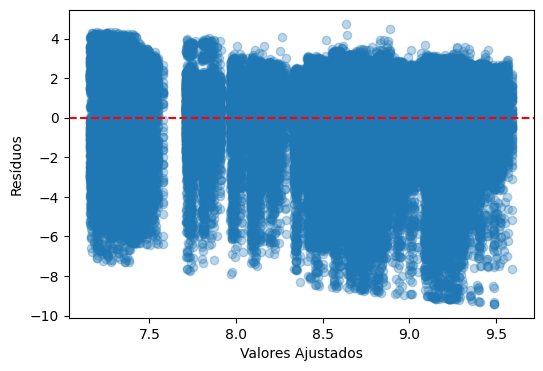

In [17]:
plt.figure(figsize=(6,4))
plt.scatter(y_pred_full, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')
plt.savefig(f'{path_img}Grafico_de_Residuos.png', dpi=300, bbox_inches='tight')
plt.show()

O gráfico de resíduos indica padrões de heterocedasticidade, com maior dispersão para valores ajustados mais altos. Isso sugere que a variância do erro não é constante, violando uma das hipóteses clássicas do modelo OLS e motivando o uso de modelos mais robustos ou não lineares nas próximas etapas.

In [18]:
# Normallidade dos Resíduos

shapiro(residuals.sample(5000, random_state=42))

ShapiroResult(statistic=np.float64(0.95126567658465), pvalue=np.float64(6.95566234417382e-38))

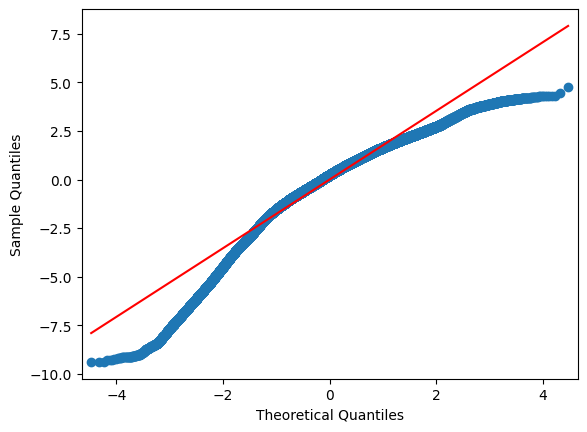

In [19]:
sm.qqplot(residuals, line='s')
plt.savefig(f'{path_img}QQPlot.png', dpi=300, bbox_inches='tight')
plt.show()

O teste de Shapiro-Wilk rejeita a hipótese de normalidade dos resíduos, o que era esperado dado o grande volume de dados. O QQ-plot confirma desvios nas caudas, indicando que inferências clássicas devem ser interpretadas com cautela, embora os coeficientes ainda forneçam insights úteis sobre direção e magnitude dos efeitos.

In [20]:
# VIF Multicolinearidade

vif_data = pd.DataFrame()
vif_data['feature'] = X_full.columns
vif_data['VIF'] = [
    variance_inflation_factor(X_full.values, i)
    for i in range(X_full.shape[1])
]

vif_data.sort_values('VIF', ascending=False)

,feature,VIF
0,const,1.955833e+07
2,Size,3.074763e+00
10,Type_C,2.616597e+00
9,Type_B,2.429560e+00
4,Fuel_Price,1.513066e+00
3,Temperature,1.426446e+00
5,CPI,1.411365e+00
6,Unemployment,1.216512e+00
7,week,1.208070e+00
8,year,1.207582e+00


Os valores de VIF não indicam multicolinearidade severa, sugerindo que as estimativas dos coeficientes são numericamente estáveis e que não há redundância excessiva entre as variáveis explicativas.

In [21]:
# Breusch–Pagan (heterocedasticidade)

bp_test = het_breuschpagan(residuals, X_full)

bp_labels = ['LM Stat', 'LM p-value', 'F Stat', 'F p-value']
dict(zip(bp_labels, bp_test))

{'LM Stat': np.float64(9433.957590824612),
 'LM p-value': np.float64(0.0),
 'F Stat': np.float64(978.8263740525668),
 'F p-value': np.float64(0.0)}

O teste de Breusch–Pagan confirma a presença de heterocedasticidade nos resíduos, reforçando os indícios observados visualmente. Esse resultado indica que, embora o OLS seja útil para inferência exploratória, modelos mais flexíveis podem capturar melhor a dinâmica das vendas.

### Regularização (Ridge / Lasso)

In [22]:
# Padronização (necessária)

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_full.drop(columns='const'))

In [23]:
# Ridge Regression

ridge = Ridge(alpha=1.0)
ridge.fit(X_scaled, y_full)

ridge_coef = pd.Series(
    ridge.coef_,
    index=X_full.drop(columns='const').columns
)

ridge_coef.sort_values(key=abs, ascending=False)

Size            0.659636
Type_B          0.189743
year           -0.052524
Type_C         -0.039329
Unemployment   -0.037634
CPI            -0.028053
Fuel_Price     -0.014373
Temperature    -0.012867
is_holiday      0.008410
week            0.003450
dtype: float64

A regressão Ridge reduz a magnitude dos coeficientes sem eliminá-los, contribuindo para maior estabilidade do modelo em cenários com múltiplas variáveis correlacionadas.

In [24]:
# Lasso Regression

lasso = Lasso(alpha=0.001)
lasso.fit(X_scaled, y_full)

lasso_coef = pd.Series(
    lasso.coef_,
    index=X_full.drop(columns='const').columns
)

lasso_coef[lasso_coef != 0].sort_values(key=abs, ascending=False)

Size            0.656633
Type_B          0.186988
year           -0.051847
Type_C         -0.040807
Unemployment   -0.036331
CPI            -0.026489
Fuel_Price     -0.013077
Temperature    -0.012870
is_holiday      0.007736
week            0.002715
dtype: float64

O Lasso confirma que o conjunto atual de variáveis é parcimonioso, mantendo ativas as features mais relevantes e reforçando que a engenharia de atributos realizada anteriormente foi adequada.

### Inferência Estatística

In [25]:
# Coeficientes e p-values

coef_table = pd.DataFrame({
    'coef': ols_model.params,
    'p_value': ols_model.pvalues
})

coef_table.sort_values('p_value')

,coef,p_value
Size,0.000011,0.000000e+00
Type_B,0.389451,1.021288e-269
const,219.029675,2.552570e-46
year,-0.105150,2.910391e-43
Unemployment,-0.020701,7.161871e-23
Type_C,-0.132189,2.304276e-12
CPI,-0.000707,9.489477e-12
Fuel_Price,-0.052373,7.461825e-04
Temperature,-0.000717,1.878774e-03
is_holiday,0.033898,1.860342e-02


In [26]:
# Intervalos de Confiança

conf_int = ols_model.conf_int()
conf_int.columns = ['lower', 'upper']

conf_int

,lower,upper
const,188.992621,249.066728
is_holiday,0.005667,0.062130
Size,0.000011,0.000011
Temperature,-0.001170,-0.000265
Fuel_Price,-0.082814,-0.021932
CPI,-0.000911,-0.000504
Unemployment,-0.024822,-0.016580
week,-0.000295,0.000803
year,-0.120091,-0.090208
Type_B,0.367723,0.411180


A análise inferencial mostra que a maioria das variáveis possui efeito estatisticamente significativo sobre as vendas. No entanto, dada a dimensão da amostra, a significância estatística deve ser interpretada em conjunto com o impacto prático e a performance preditiva.

### Comparação Final com Baseline

In [27]:
# Tabela Comparativa

comparison = pd.DataFrame([
    {'Model': 'Baseline OLS', **baseline_metrics},
    {'Model': 'OLS Completo', **ols_metrics}
])

comparison

,Model,RMSE,MAE,R2
0,Baseline OLS,1.779441,1.365968,0.101592
1,OLS Completo,1.768066,1.352228,0.113041


A comparação direta evidencia que o modelo completo supera o baseline em todas as métricas avaliadas, estabelecendo um patamar mais realista para a performance de modelos lineares neste problema.

In [28]:
# Encerramento Técnico

comparison.sort_values('RMSE')

,Model,RMSE,MAE,R2
1,OLS Completo,1.768066,1.352228,0.113041
0,Baseline OLS,1.779441,1.365968,0.101592


Os modelos OLS fornecem uma base interpretável sólida e estabelecem um limite inferior de desempenho para o problema. A partir desse ponto, modelos mais flexíveis como XGBoost, SARIMAX e LSTM serão avaliados para capturar relações não lineares e dependências temporais mais complexas.